In [51]:
import nilearn
from nilearn.glm.first_level import first_level_from_bids
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [3]:
# data folder
data_dir='../InSpePosNegData/BIDS_2023E/' 
# derivatives folder (preprocessed data)
derivatives_dir='derivatives'  

# name of experiment
task_label = 'boldinnerspeech'
# label for spatially aligned data
#space_label ='MNI152NLin2009cAsym'
# run the function that can gather all the needed info from a BIDS folder
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label, derivatives_folder=derivatives_dir, n_jobs=6, verbose=0,
        img_filters=[('desc', 'preproc')])

/work/neuro_4/neuro_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1148: UserWarning: 'slice_time_ref' provided (0.0) is different from the value found in the BIDS dataset (0.462).
Note this may lead to the wrong model specification.
  warn(


In [34]:
# confirming that index 5 is participant 118
print(models[5])
print(models_events[5])

# no way to tell whether the confounds and models_run_img are participant 118, lets hope so
print(models_confounds[5])
print(models_run_imgs[5])

models_118 = models[5]
run_imgs_118 = models_run_imgs[5]

FirstLevelModel(n_jobs=6, subject_label='0118', t_r=1)
[         onset  duration trial_type cued_word_pos cued_word_neg response  \
0     1.007677  0.688785     IMG_NS     wonderful      pathetic      NaN   
1     6.313886  0.699925     IMG_PS     wonderful      pathetic      NaN   
2    11.630686  0.699659     IMG_BI     wonderful      pathetic        b   
3    17.947682  0.699587     IMG_PS     wonderful      pathetic      NaN   
4    24.264465  0.699933     IMG_NS     wonderful      pathetic      NaN   
..         ...       ...        ...           ...           ...      ...   
85  453.935742  0.700058     IMG_NS     wonderful      pathetic      NaN   
86  458.255634  0.696938     IMG_NS     wonderful      pathetic      NaN   
87  464.569964  0.700019     IMG_NS     wonderful      pathetic      NaN   
88  468.888167  0.698301     IMG_PS     wonderful      pathetic      NaN   
89  473.203578  0.699721     IMG_BI     wonderful      pathetic        b   

          RT  run   ID         

In [35]:
# Subset confounds
confound_friston24 = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

confound_friston24_GSR = ['global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2','trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

# Subset confounds with selection
for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_friston24_GSR]
        #Removing NAs in the first row.
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1

# Set confounds for participant 118
confounds_118 = models_confounds[5]

In [ ]:
events_sub= ['onset','duration','trial_type']

# Subset model events with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
        #Rename trials to make contrasting easier
        events1[i].replace({'IMG_NS': 'N', 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P','IMG_BI': 'B'}, inplace = True)

       
    models_events[ii][:]=events1

# Set events for participant 118
events_118 = models_events[5]

In [41]:
lsa_dm=[]

# Changing the model for a single participant (the first):
for ii in range(len(events_118)):
    # Sort onsets by trial type to make later processing easier
    #events_118[ii].sort_values(by=['trial_type'], inplace=True)
     #N=number of events
    N=events_118[ii].shape[0]
    # time frame with 490 scans with 1s TR:
    t_fmri = np.linspace(0, 490,490,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(events_118[ii], columns=['onset'])
    trials.loc[:, 'duration'] = 0.7
    trials.loc[:, 'trial_type'] = [events_118[ii]['trial_type'][i-1]+'_'+'t_'+str(i).zfill(3)  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        add_regs=models_confounds[0][ii], #Add the confounds from fmriprep
        hrf_model='glover',
        drift_model='cosine'  
    ))

/work/neuro_4/neuro_env/lib/python3.10/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


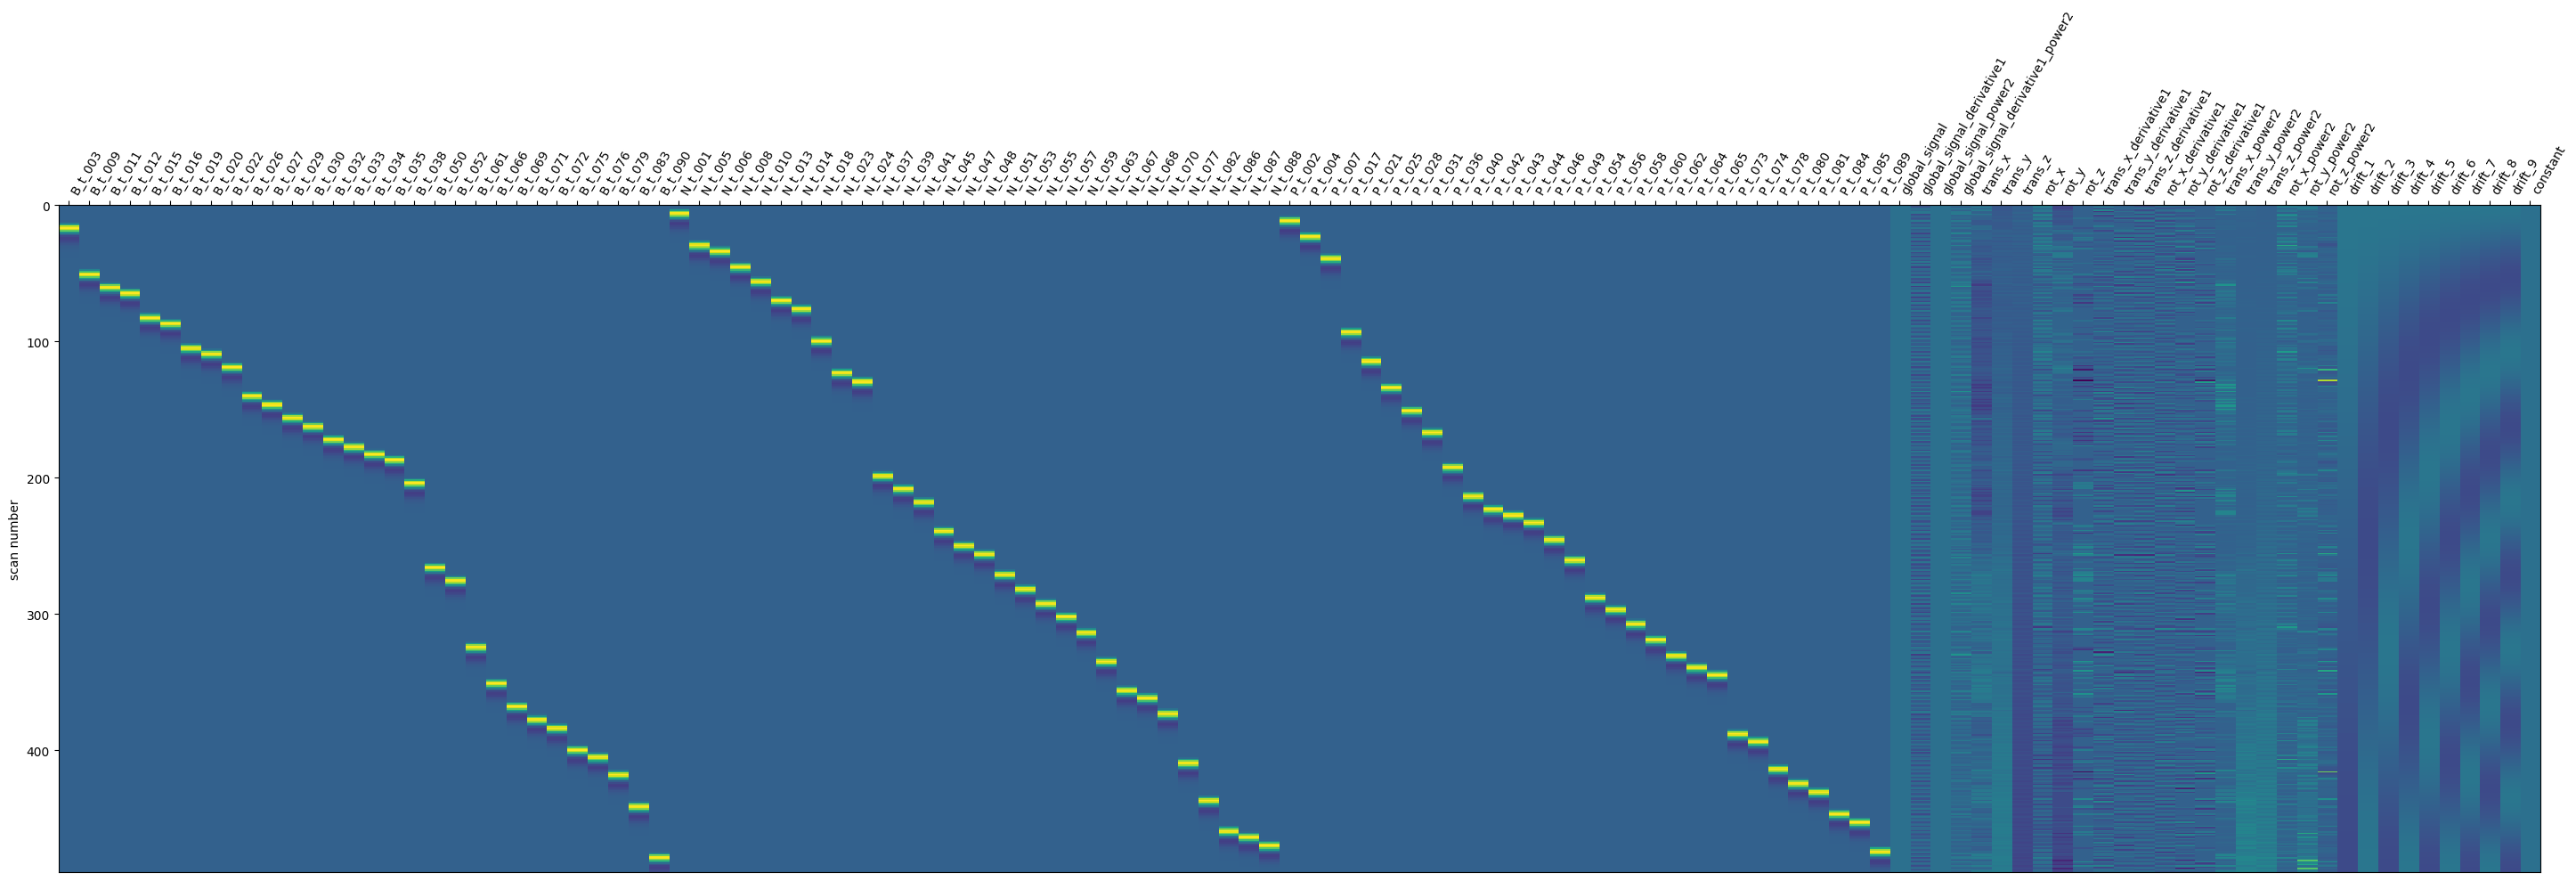

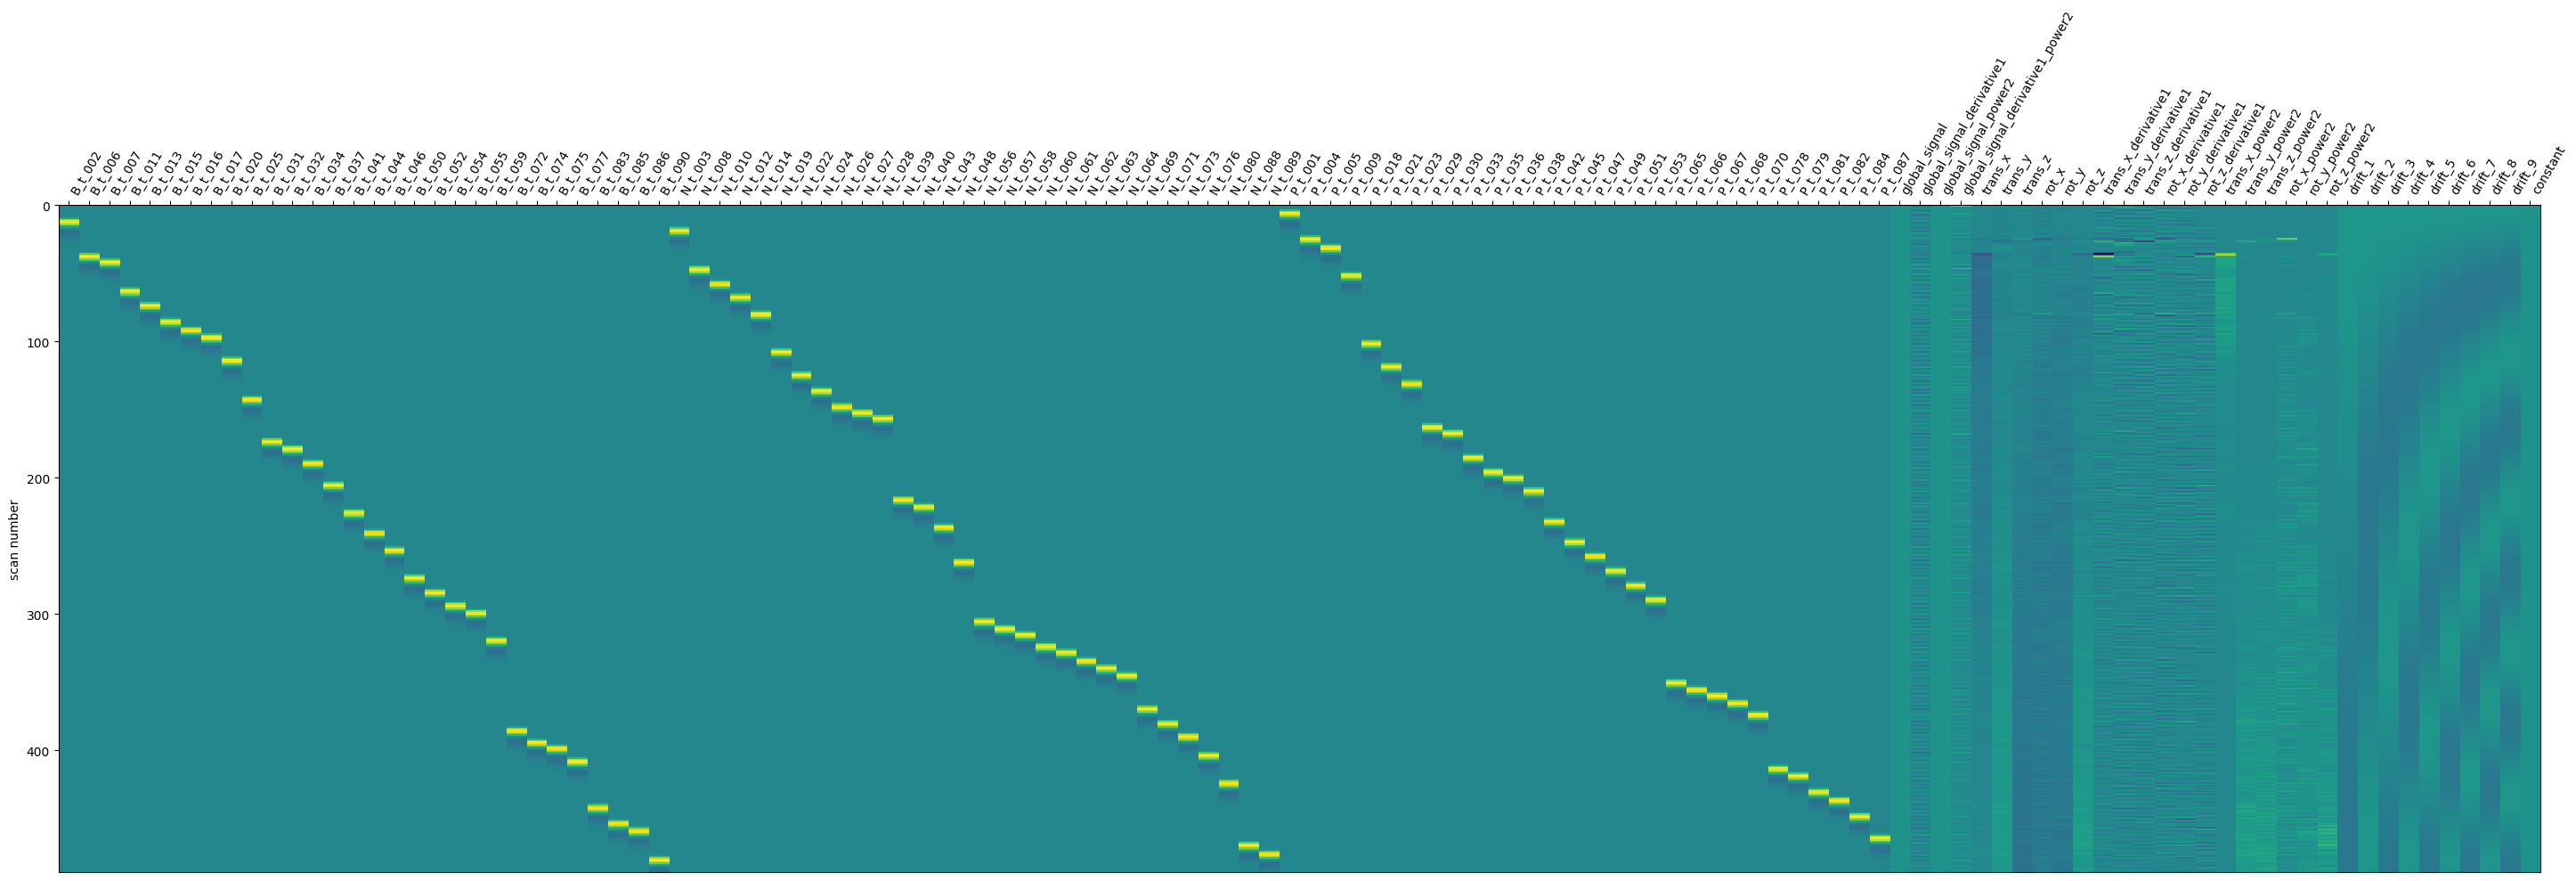

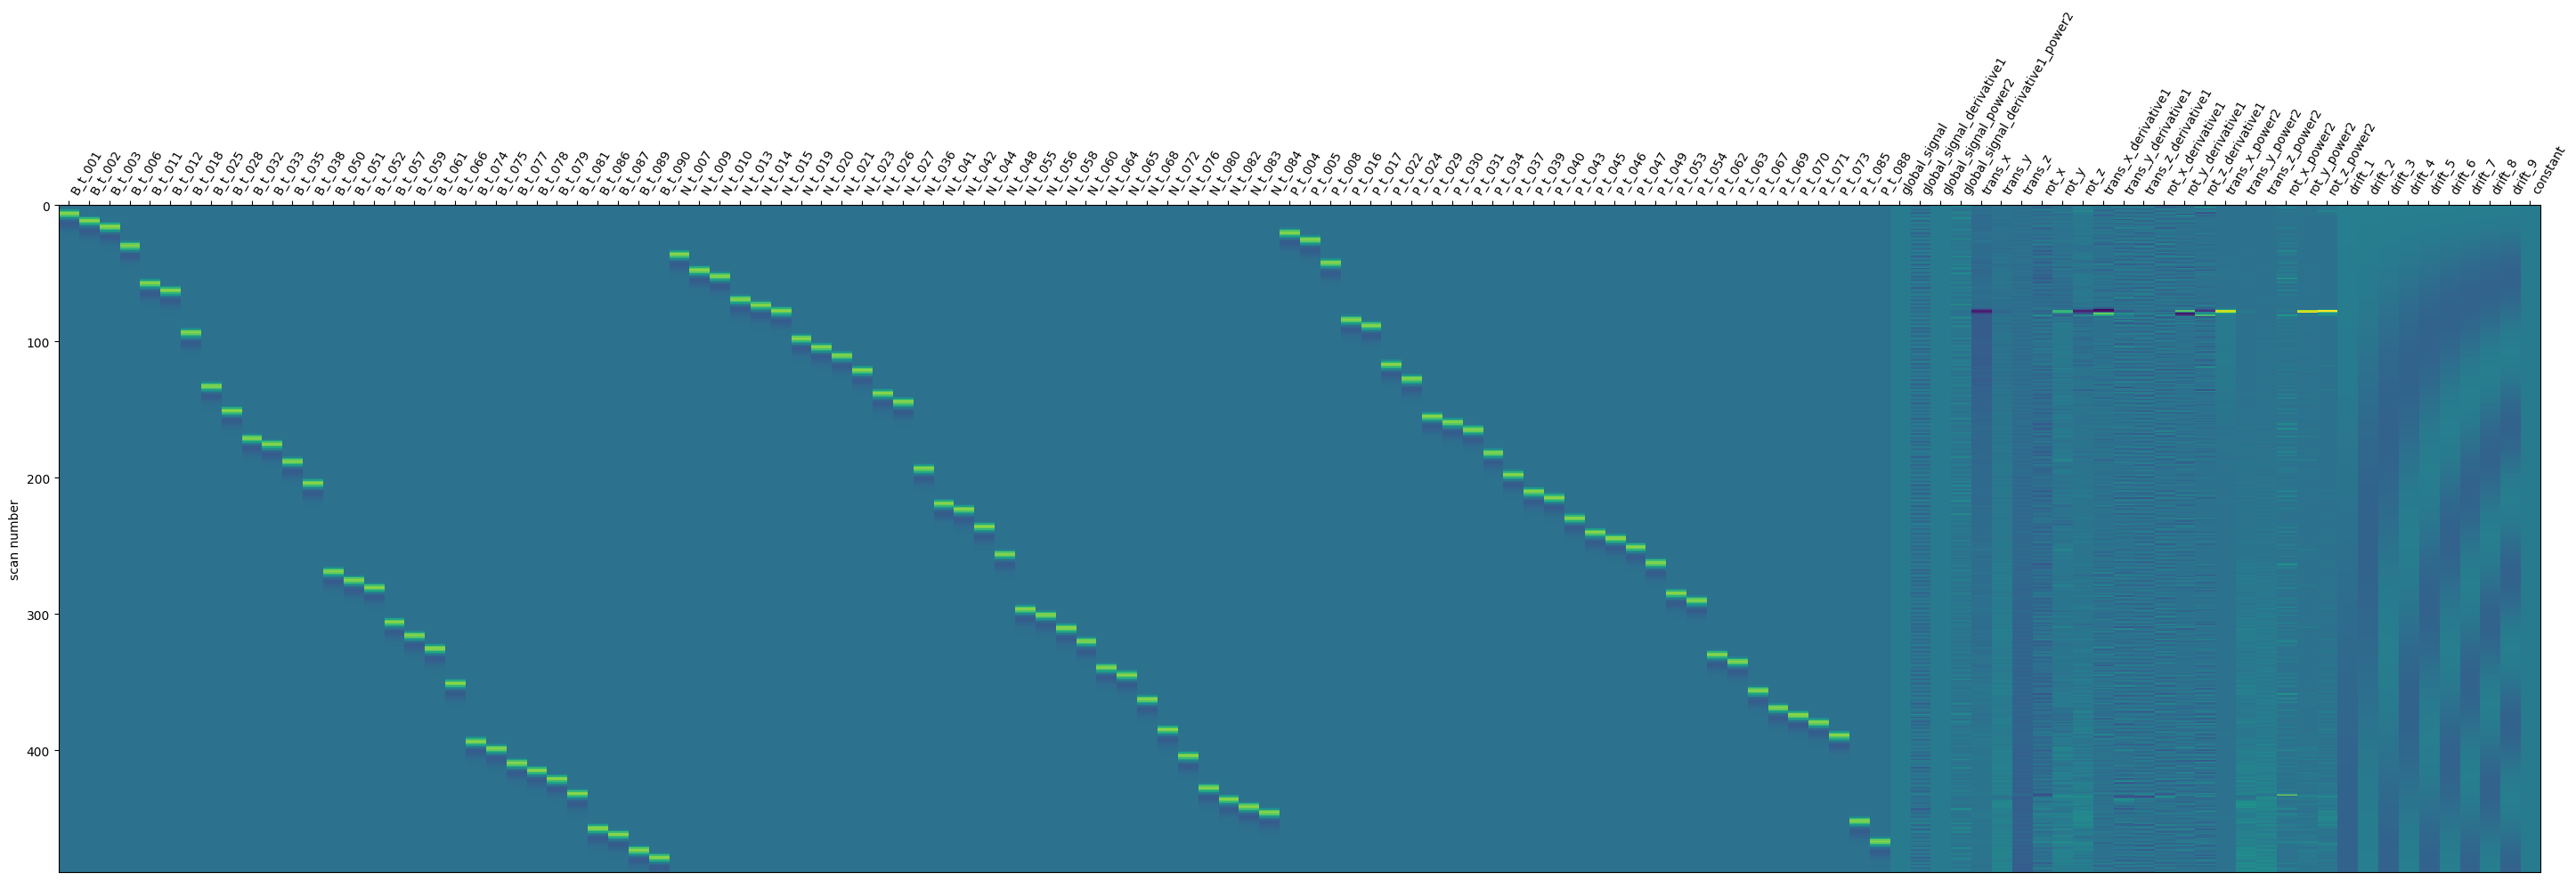

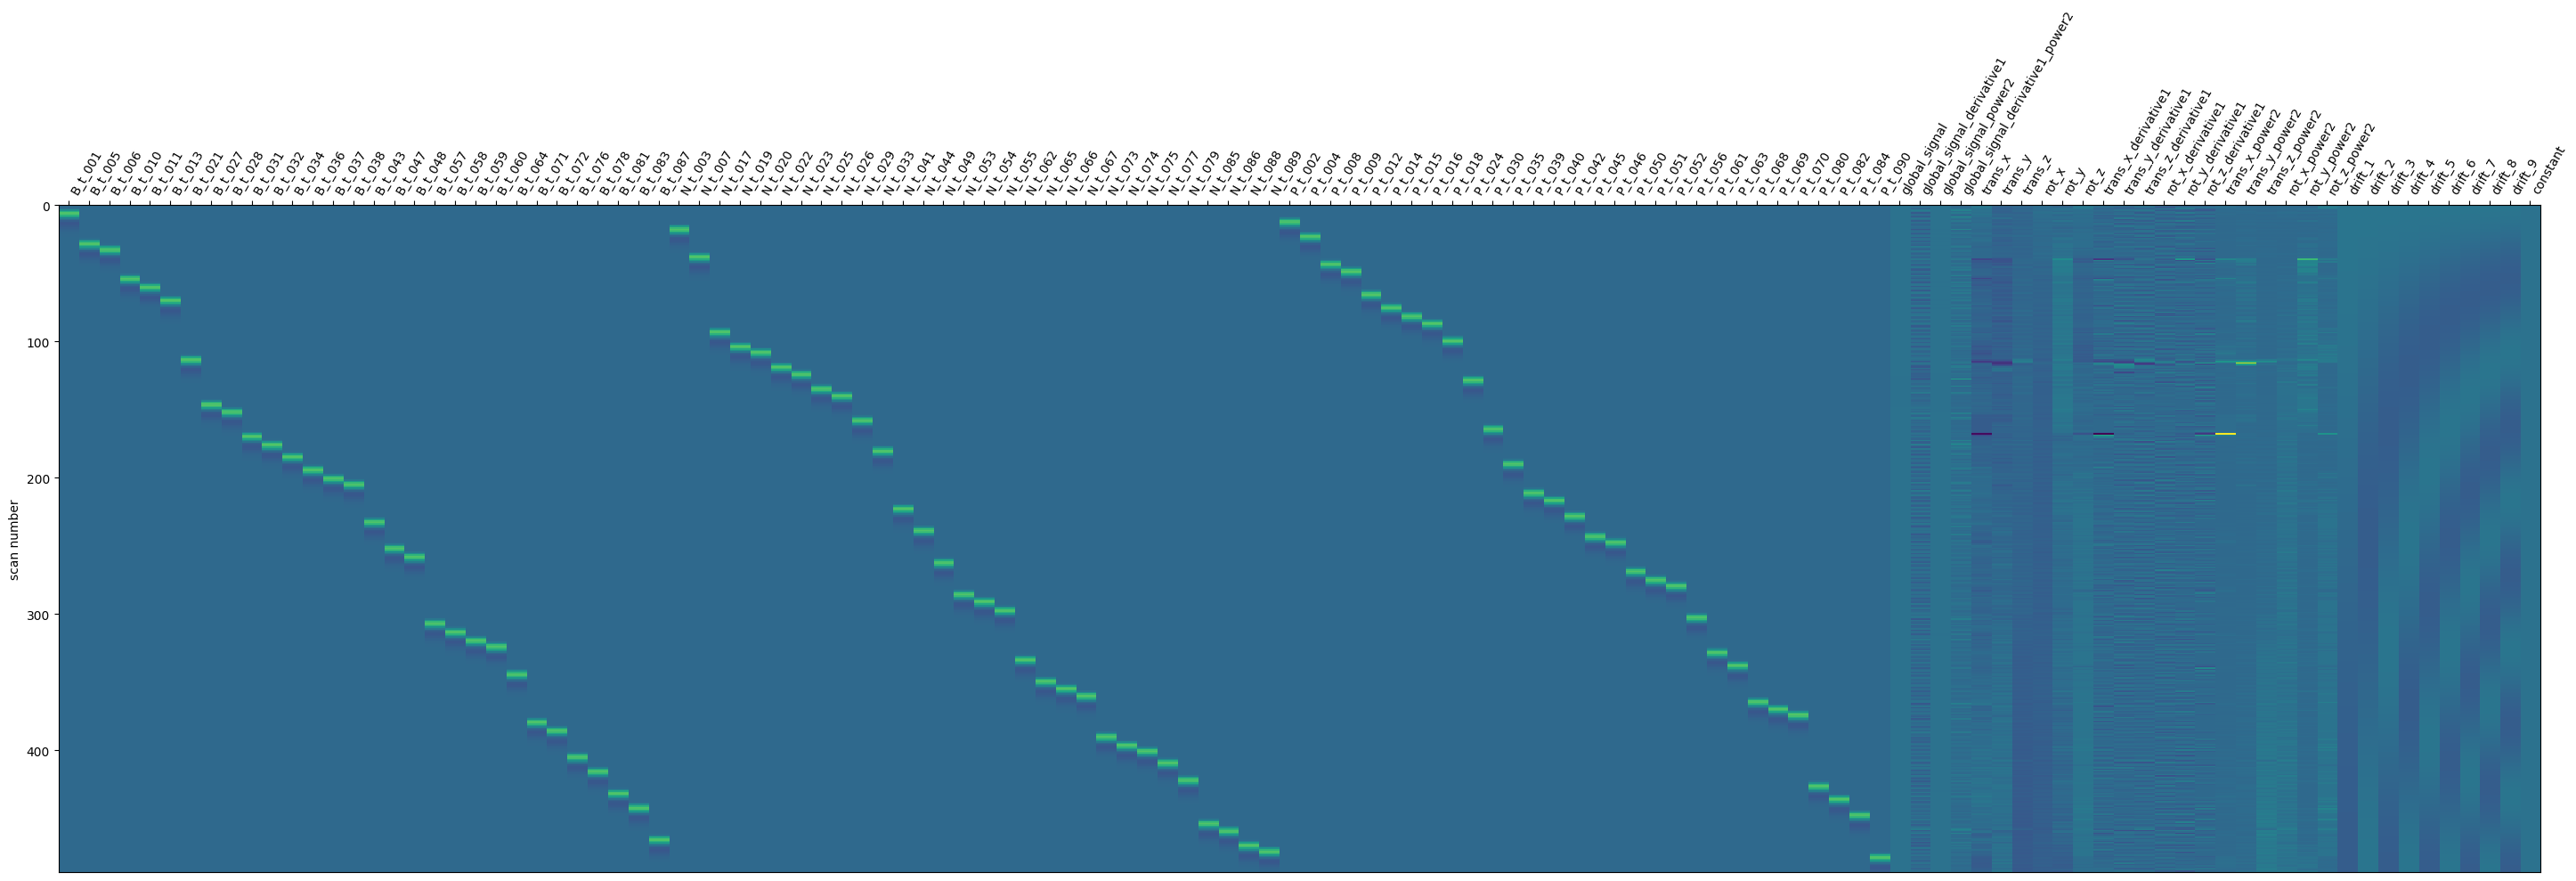

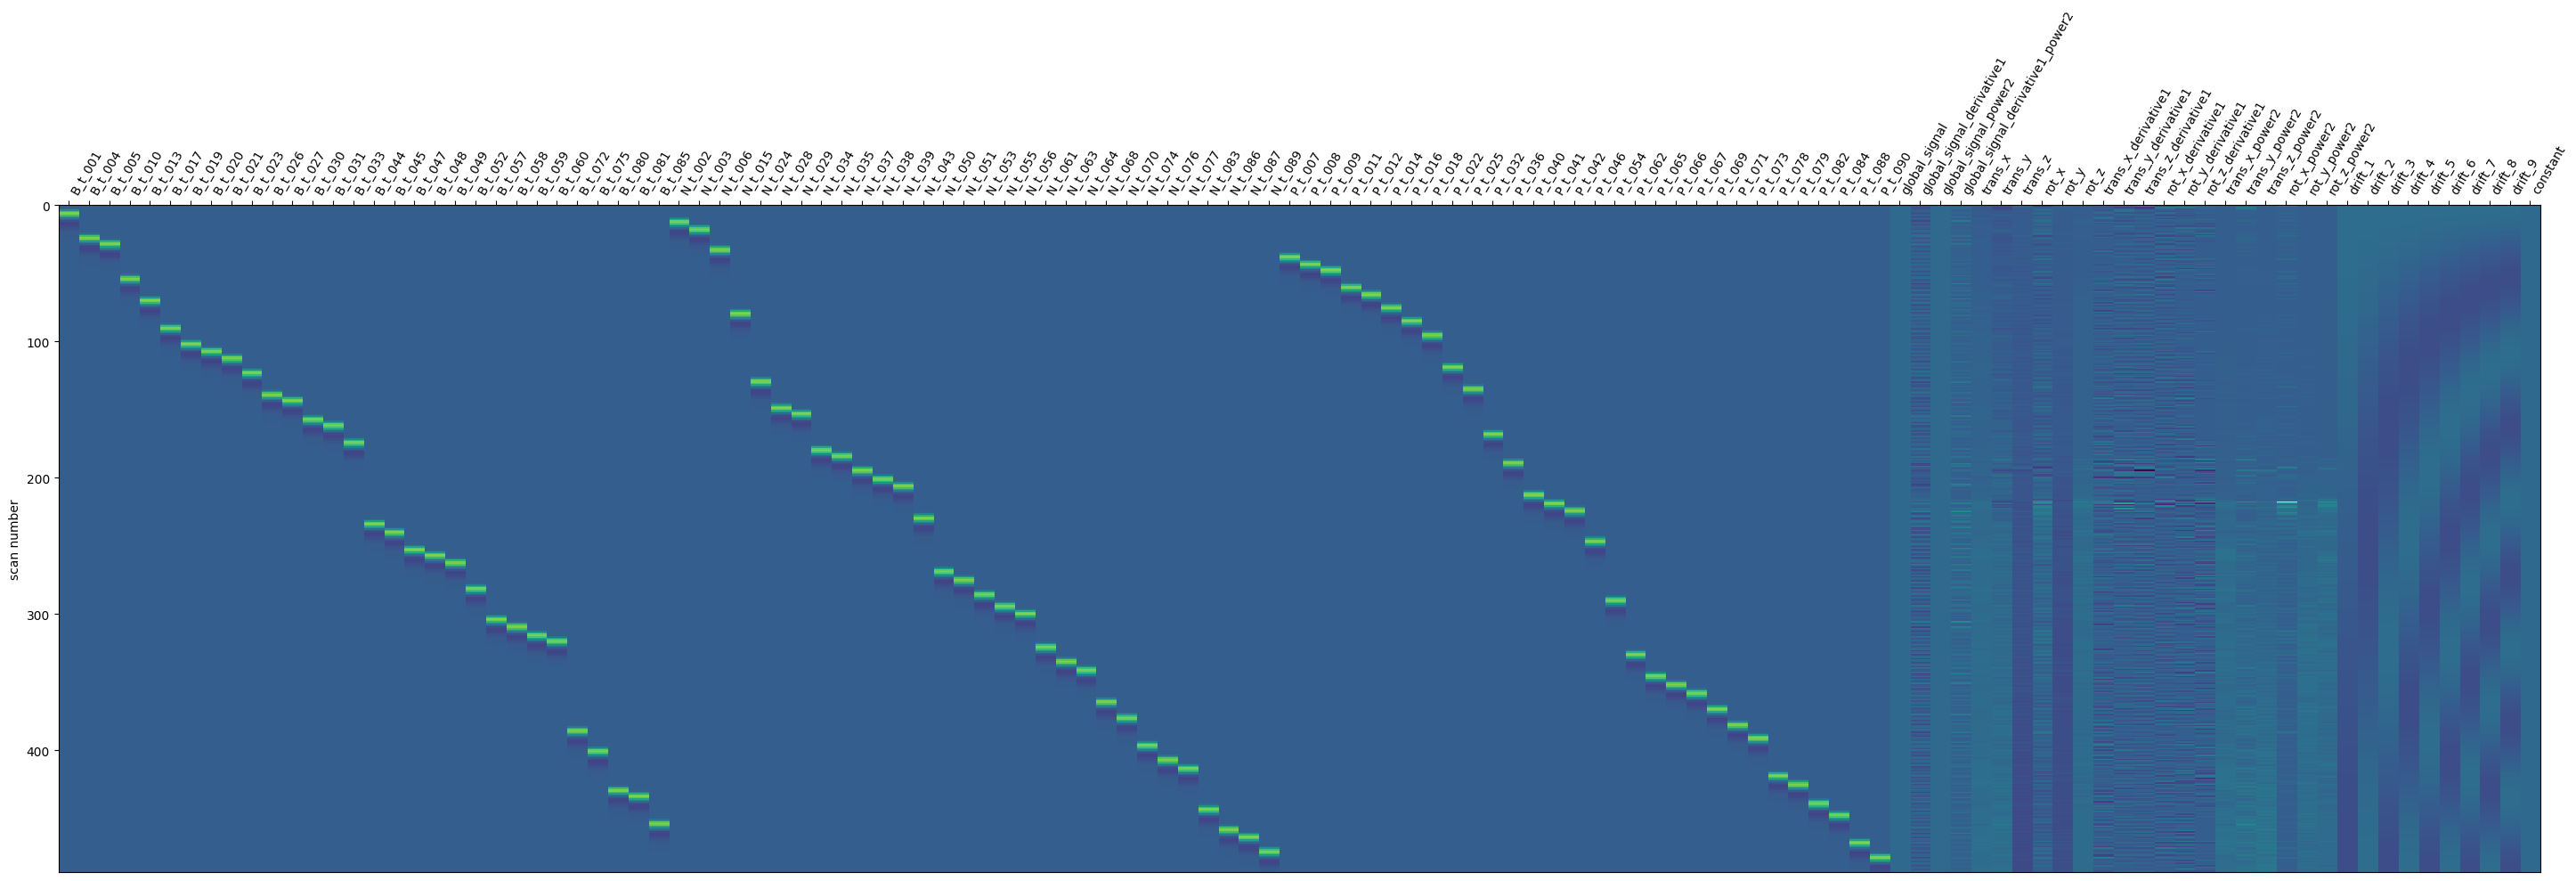

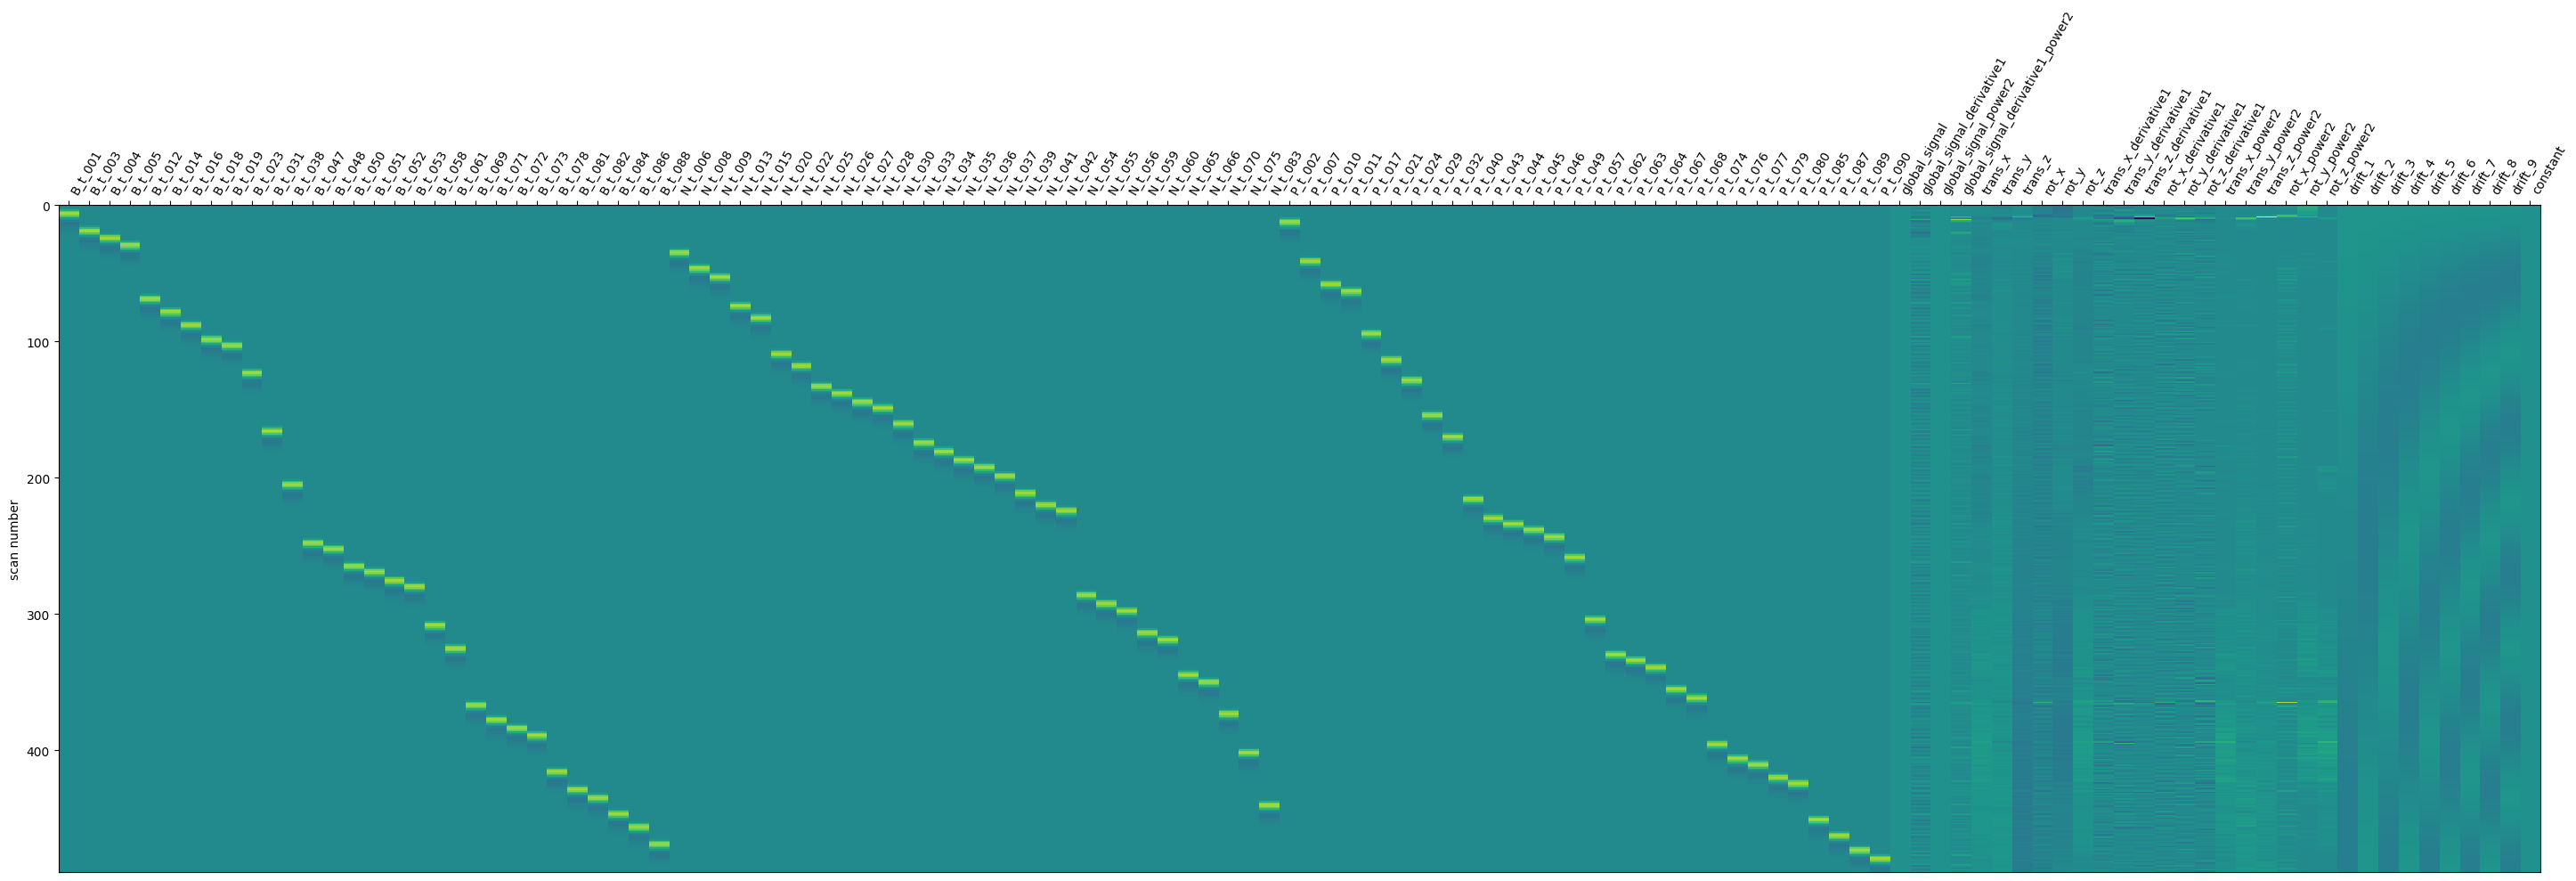

In [45]:
for ii in range(len(events_118)):
    plot_design_matrix(lsa_dm[ii]);

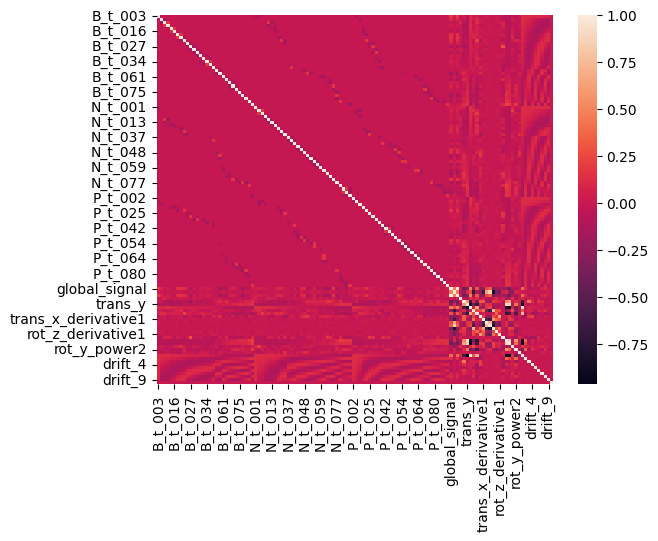

In [47]:
dm_corr=lsa_dm[0].corr()
p1 = sns.heatmap(dm_corr)

In [49]:
model1=[]
for ii in range(len(events_118)):
    
    # Get data and model info for 1st participant, 1st session
    imgs1 = run_imgs_118[ii]
    model1.append(FirstLevelModel())
    #Fit the model
    print('Fitting GLM: ', ii+1)
    model1[ii].fit(imgs1,design_matrices=lsa_dm[ii])

Fitting GLM:  1
Fitting GLM:  2
Fitting GLM:  3
Fitting GLM:  4
Fitting GLM:  5
Fitting GLM:  6


In [53]:
b_maps = []
conditions_label = []

for ii in range(len(events_118)):
    N=events_118[ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N)
    #print(contrasts.shape)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    #print(dif)
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    #print(contrasts.shape)
    print('Making contrasts for session : ', ii+1)
    print('Number of contrasts : ', N)
    for i in range(N):
        #Add a beta-contrast image from each trial
        b_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='effect_size'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(lsa_dm[ii].columns[i])
#        session_label.append(session)

Making contrasts for session :  1
Number of contrasts :  90
Making contrasts for session :  2
Number of contrasts :  90
Making contrasts for session :  3
Number of contrasts :  90
Making contrasts for session :  4
Number of contrasts :  90
Making contrasts for session :  5
Number of contrasts :  90
Making contrasts for session :  6
Number of contrasts :  90


In [ ]:

now = datetime.now()
print('Renaming labels to N, P, and B:',now.strftime("%H:%M:%S"))

f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
f.close()

import numpy as np
#from nilearn import datasets
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from sklearn.model_selection import train_test_split, GroupKFold
n_trials=len(conditions_label)
#print(n_trials)

#Concatenate beta maps
b_maps_conc=concat_imgs(b_maps)
#print(b_maps_conc.shape)
del b_maps
# Reshaping data------------------------------
from nilearn.image import index_img, concat_imgs
#Find all negative and positive trials
idx_neg=[int(i) for i in range(len(conditions_label)) if 'N_' in conditions_label[i]]
idx_pos=[int(i) for i in range(len(conditions_label)) if 'P_' in conditions_label[i]]
idx_but=[int(i) for i in range(len(conditions_label)) if 'B_' in conditions_label[i]]

#print(idx_neg)
#print(conditions_label)
for i in range(len(conditions_label)):
    if i in idx_neg:
        conditions_label[i]='N'
    if i in idx_pos:
        conditions_label[i]='P'
    if i in idx_but:
        conditions_label[i]='B'
print(conditions_label)

now = datetime.now()
print('Selecting to N and B:',now.strftime("%H:%M:%S"))
# Make index of relevant trials
idx=np.concatenate((idx_neg, idx_but))
#print(idx)

#Select trials
conditions=np.array(conditions_label)[idx]
print(conditions)

#Select images
b_maps_img = index_img(b_maps_conc, idx)
print(b_maps_img.shape)


In [ ]:
now = datetime.now()
print('Making a trial and test set:',now.strftime("%H:%M:%S"))
#conditions_img=conditions[idx]
#print(conditions_img)
#Make an index for spliting fMRI data with same size as class labels
idx2=np.arange(conditions.shape[0])

# create training and testing vars on the basis of class labels
idx_train,idx_test, conditions_train,  conditions_test = train_test_split(idx2,conditions, test_size=0.2)
#print(idx_train, idx_test)

# Reshaping data------------------------------
from nilearn.image import index_img
fmri_img_train = index_img(b_maps_img, idx_train)
fmri_img_test = index_img(b_maps_img, idx_test)
#Check data sizes
print('Trial and test set shape:')
print(fmri_img_train.shape)
print(fmri_img_test.shape)

# Saving the objects:
f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_testtrain.pkl', 'wb')
pickle.dump([fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test], f)
f.close()

now = datetime.now()
print('Trial and test set saved:',now.strftime("%H:%M:%S"))